# Basic Data Exploration 

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import plotly.graph_objects as go
import numpy as np
import torch 
from torch.nn import functional as F

### Basic utility functions 

In [ ]:
def load_npy(file_path):
    """Load a .npy file and return its content."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    data = np.load(file_path, allow_pickle=True)
    return data


def load_rgb_image(image_path):
    """Load an RGB image from a file path."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file {image_path} does not exist.")
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image file {image_path}.")
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

def plot_mask_on_image(image, masks):
    """
    Plot masks on an image with red contours, slightly dimmed inside, and display the mask number.
    
    Args:
        image (np.ndarray): The RGB image on which to plot the masks.
        masks (np.ndarray): The masks to be plotted.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    
    for i, mask in enumerate(masks):
        if mask.ndim == 2:  # Check if mask is 2D
            # Create a dimmed version of the image inside the mask
            dimmed_image = image.copy()
            dimmed_image[mask] = (dimmed_image[mask] * 0.5).astype(np.uint8)
            ax.imshow(dimmed_image, alpha=0.9)
            
            # Find contours of the mask
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                ax.add_patch(patches.Polygon(contour.squeeze(), edgecolor='red', fill=False, linewidth=2))
            
            # Calculate the center of the mask to display the mask number
            y, x = np.where(mask)
            if len(x) > 0 and len(y) > 0:
                center_x, center_y = int(np.mean(x)), int(np.mean(y))
                ax.text(center_x, center_y, str(i + 1), color='red', fontsize=12, ha='center', va='center')
    
    plt.axis('off')
    plt.show()

def plot_3d_bboxes_on_image(image, bboxes, pc):
    """
    Plot 3D bounding boxes on an image. APPROXIMATELY.
    
    Args:
        image (np.ndarray): The RGB image on which to plot the bounding boxes.
        bboxes (np.ndarray): The 3D bounding boxes to be plotted, shape (N, 8, 3).
    """
    # find max and min ranges from pc 
    x_min, x_max = pc[0].min(), pc[0].max()
    y_min, y_max = pc[1].min(), pc[1].max()

    # Normalize the bounding boxes to the image size
    bboxes = bboxes.copy()
    bboxes[:, :, 0] = (bboxes[:, :, 0] - x_min) / (x_max - x_min) * image.shape[1]
    bboxes[:, :, 1] = (bboxes[:, :, 1] - y_min) / (y_max - y_min) * image.shape[0]
    bboxes[:, :, 2] = 0  # Set z-coordinate to 0

    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    
    for bbox in bboxes:
        # Project the 3D bounding box to 2D
        for i in range(4):
            start = bbox[i]
            end = bbox[(i + 1) % 4]
            ax.plot([start[0], end[0]], [start[1], end[1]], color='red', linewidth=2)
        
        for i in range(4, 8):
            start = bbox[i]
            end = bbox[(i + 1) % 4 + 4]
            ax.plot([start[0], end[0]], [start[1], end[1]], color='red', linewidth=2)
        
        for i in range(4):
            start = bbox[i]
            end = bbox[i + 4]
            ax.plot([start[0], end[0]], [start[1], end[1]], color='red', linewidth=2)
    
    plt.axis('off')
    plt.show()

def plot_multiple_3d_bboxes_interactive(corners_list, colors=None):
    """
    Plot multiple 3D bounding boxes interactively
    Args:
        corners_list: list of numpy arrays or tensors, each of shape (8, 3)
        colors: list of colors for each bbox
    """
    if colors is None:
        colors = ['blue'] * len(corners_list)
    
    # Create figure
    fig = go.Figure()
    
    # Define the edges of the box
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # connecting edges
    ]
    
    for corners, color in zip(corners_list, colors):
        corners = np.array(corners)
        
        # Add edges as lines
        for edge in edges:
            fig.add_trace(go.Scatter3d(
                x=[corners[edge[0]][0], corners[edge[1]][0]],
                y=[corners[edge[0]][1], corners[edge[1]][1]],
                z=[corners[edge[0]][2], corners[edge[1]][2]],
                mode='lines',
                line=dict(color=color, width=2),
                showlegend=False
            ))
        
        # Add corners as points
        fig.add_trace(go.Scatter3d(
            x=corners[:, 0],
            y=corners[:, 1],
            z=corners[:, 2],
            mode='markers',
            marker=dict(size=4, color=color),
            showlegend=False
        ))
    
    # Update layout
    fig.update_layout(
        scene=dict(
            aspectmode='data',
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=800,
        margin=dict(l=0, r=0, t=0, b=0)
    )
    
    fig.show()

def visualize_pointcloud(points, downsample_factor=5):
    """
    Visualize point cloud with downsampling
    Args:
        points: numpy array of shape (3, H, W)
        downsample_factor: factor to downsample points
    """
    # Downsample the points
    points_down = points[:, ::downsample_factor, ::downsample_factor]
    
    # Reshape to (3, N)
    points_reshaped = points_down.reshape(3, -1)
    
    # Remove points where all coordinates are 0 (often indicates no measurement)
    mask = ~np.all(points_reshaped == 0, axis=0)
    points_filtered = points_reshaped[:, mask]

    # Create figure
    fig = go.Figure(data=[go.Scatter3d(
        x=points_filtered[0],
        y=points_filtered[1],
        z=points_filtered[2],
        mode='markers',
        marker=dict(
            size=2,
            color=points_filtered[2],  # color by z-coordinate
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    # Update layout
    fig.update_layout(
        scene=dict(
            aspectmode='data',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        width=800,
        height=800,
        margin=dict(l=0, r=0, t=0, b=0)
    )

    fig.show()

### Visualize single sample

In [3]:
path_bbox = "/home/hao1rng/sec_proj/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/bbox3d.npy"
path_mask = "/home/hao1rng/sec_proj/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/mask.npy"
path_pc   = "/home/hao1rng/sec_proj/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/pc.npy"
path_rgb = "/home/hao1rng/sec_proj/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/rgb.jpg"

bbox3d = load_npy(path_bbox)
mask3d = load_npy(path_mask)
pc3d   = load_npy(path_pc)
rgb_image = load_rgb_image(path_rgb)

In [4]:
print(f"bbox3d shape: {bbox3d.shape}")
print(f"mask3d shape: {mask3d.shape}")
print(f"pc3d shape: {pc3d.shape}")

bbox3d shape: (4, 8, 3)
mask3d shape: (4, 481, 607)
pc3d shape: (3, 481, 607)


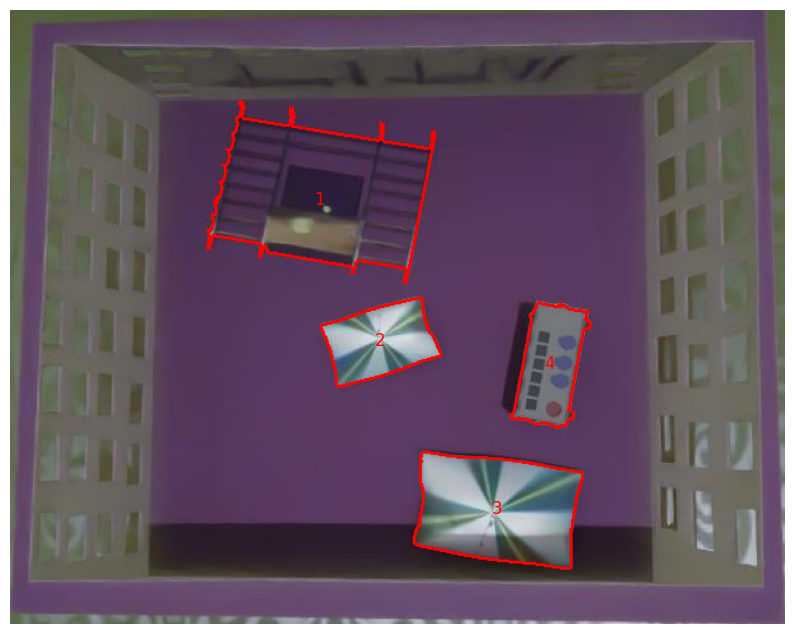

In [5]:
# Plot mask on image
plot_mask_on_image(rgb_image, mask3d)

In [6]:
bbox3d[1]

array([[-0.07248997,  0.01421412,  1.1153076 ],
       [-0.06975526,  0.01257132,  1.1455299 ],
       [-0.05129497,  0.0761691 ,  1.1473163 ],
       [-0.05402997,  0.07781187,  1.1170939 ],
       [ 0.03065904, -0.01541889,  1.1043624 ],
       [ 0.03339405, -0.01706166,  1.1345847 ],
       [ 0.05185409,  0.04653609,  1.1363713 ],
       [ 0.04911905,  0.04817889,  1.106149  ]], dtype=float32)

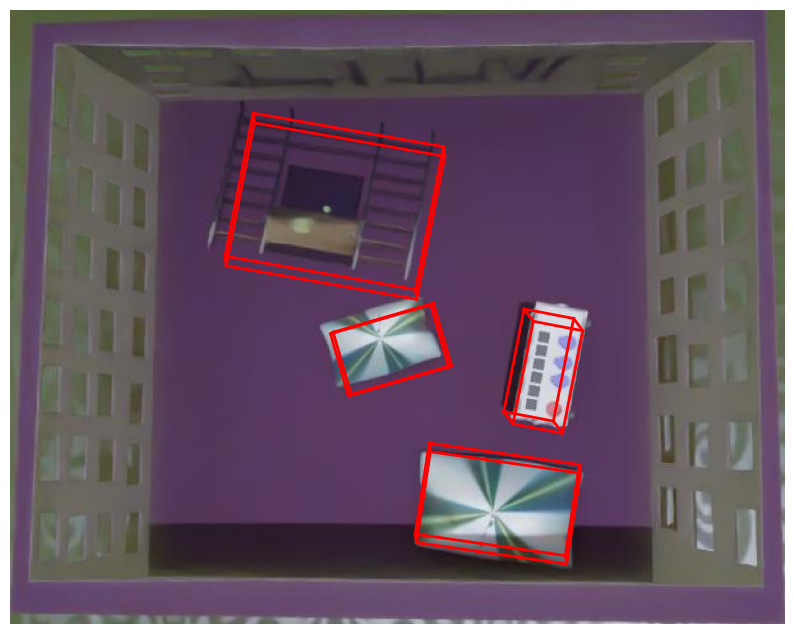

In [7]:
plot_3d_bboxes_on_image(rgb_image, bbox3d, pc3d)    

In [8]:
colors = ['blue', 'red', 'green', 'orange']
plot_multiple_3d_bboxes_interactive(bbox3d[:4], colors)

In [9]:
visualize_pointcloud(pc3d)

### Analyze resolution of images 

In [ ]:
def save_image_resolutions(base_path):
    """
    Traverse through all subfolders in the given path, load 'rgb.jpg' if present, and save its resolution.

    Args:
        base_path (str): The base directory to search for 'rgb.jpg'.
        output_file (str): The file to save the resolutions.
    """
    resolutions = []
    for root, dirs, files in os.walk(base_path):
        if 'rgb.jpg' in files:
            image_path = os.path.join(root, 'rgb.jpg')
            image = cv2.imread(image_path)
            if image is not None:
                height, width, _ = image.shape
                resolutions.append((width, height))

    return np.array(resolutions)


base_path = "/home/hao1rng/sec_proj/processed_dataset"
resolutions= save_image_resolutions(base_path)

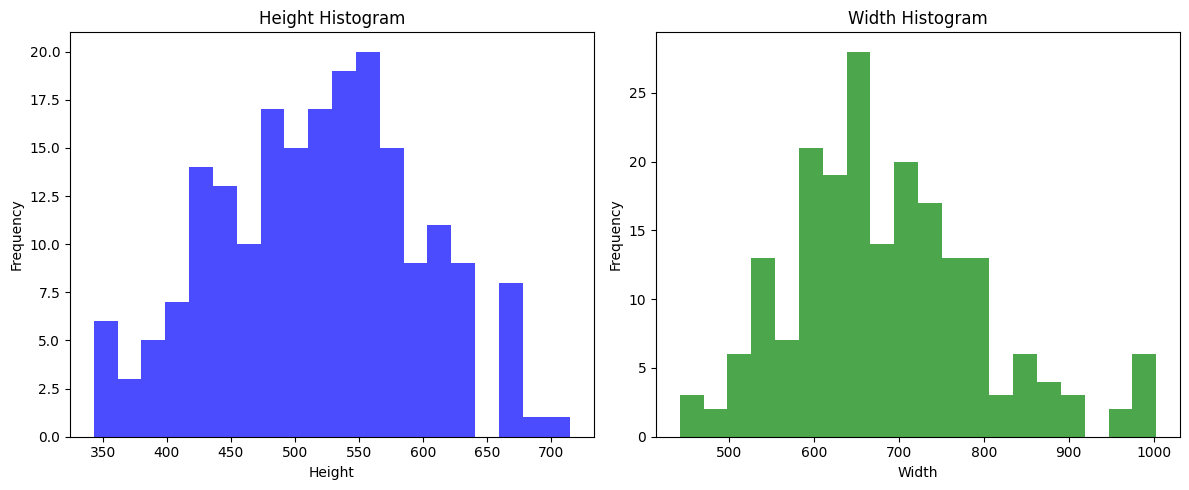

In [ ]:
def plot_resolution_histogram(resolutions, bins_h, bins_w):
    """
    Plot histograms for height and width from the resolutions array.

    Args:
        resolutions (np.ndarray): Array of shape (B, 2) containing width and height.
        bins_h (int): Number of bins for the height histogram.
        bins_w (int): Number of bins for the width histogram.
    """
    heights = resolutions[:, 1]
    widths = resolutions[:, 0]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram for heights
    axes[0].hist(heights, bins=bins_h, color='blue', alpha=0.7)
    axes[0].set_title('Height Histogram')
    axes[0].set_xlabel('Height')
    axes[0].set_ylabel('Frequency')

    # Histogram for widths
    axes[1].hist(widths, bins=bins_w, color='green', alpha=0.7)
    axes[1].set_title('Width Histogram')
    axes[1].set_xlabel('Width')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


plot_resolution_histogram(resolutions, bins_h=20, bins_w=20)

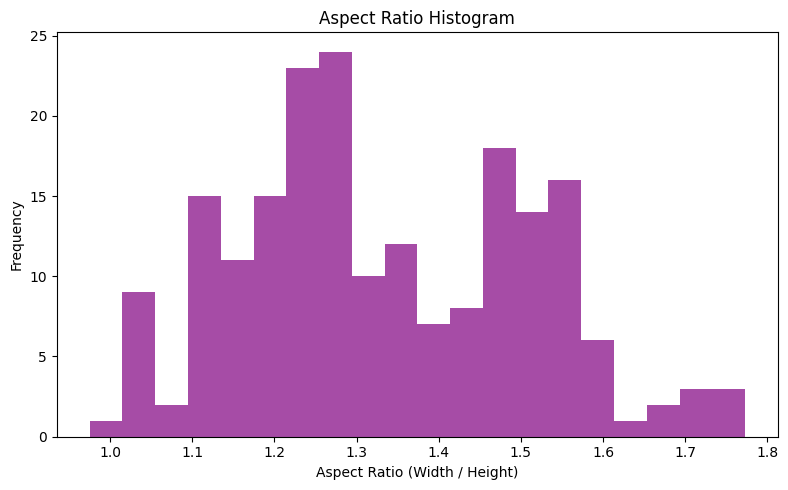

In [ ]:
def plot_aspect_ratio_histogram(resolutions, bins=20):
    """
    Plot a histogram for aspect ratios from the resolutions array.

    Args:
        resolutions (np.ndarray): Array of shape (B, 2) containing width and height.
        bins (int): Number of bins for the aspect ratio histogram.
    """
    # Calculate aspect ratios
    aspect_ratios = resolutions[:, 0] / resolutions[:, 1]

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(aspect_ratios, bins=bins, color='purple', alpha=0.7)
    plt.title('Aspect Ratio Histogram')
    plt.xlabel('Aspect Ratio (Width / Height)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_aspect_ratio_histogram(resolutions, bins=20)

In [15]:
# calculate avera H, W and aspect ratio
averate_height = np.mean(resolutions[:, 1])
average_width = np.mean(resolutions[:, 0])
average_aspect_ratio = average_width / averate_height

print(f"Average Height: {averate_height}, Average Width: {average_width}, Average Aspect Ratio: {average_aspect_ratio}")

Average Height: 517.08, Average Width: 684.625, Average Aspect Ratio: 1.3240214280188751


### Interpolate point cloud

In [16]:
def interpolate_point_cloud(pc, target_size=(224, 224)):
    """Interpolate a point cloud to a fixed size."""

    pc = torch.tensor(pc).unsqueeze(0) 
    pc_interp = F.interpolate(pc, size=target_size, mode='bilinear', align_corners=False)
    return pc_interp.squeeze(0).numpy() 


pc_interpolated = interpolate_point_cloud(pc3d, target_size=(224, 224))
print(f"Interpolated Point Cloud Shape: {pc_interpolated.shape}")

# visualize the interpolated point cloud
visualize_pointcloud(pc_interpolated, downsample_factor=2)

Interpolated Point Cloud Shape: (3, 224, 224)
